In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import reduce
from scipy.stats import multivariate_normal
from sklearn.svm import SVC
from numpy.random import default_rng
from sklearn.datasets import make_classification
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import (GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from utils import DataGenerator, draw_barplot

>#### 1. Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

Тренировочный семпл в данной задаче представляет собой пару координат (x, y), принадлежащей комбинации нормальных распределений, и метку класса (1, 2). 

In [3]:
max_dim = 6
gen = DataGenerator(max_dim=max_dim)

В ячейке ниже представлены примеры генерируемых полей, представляющих собой комбинацию нормальных распределений с рандомизированными параметрами (в частности рандомизируются средние значения, а матрицы ковариации выбираются случайно из заранее заданного набора)

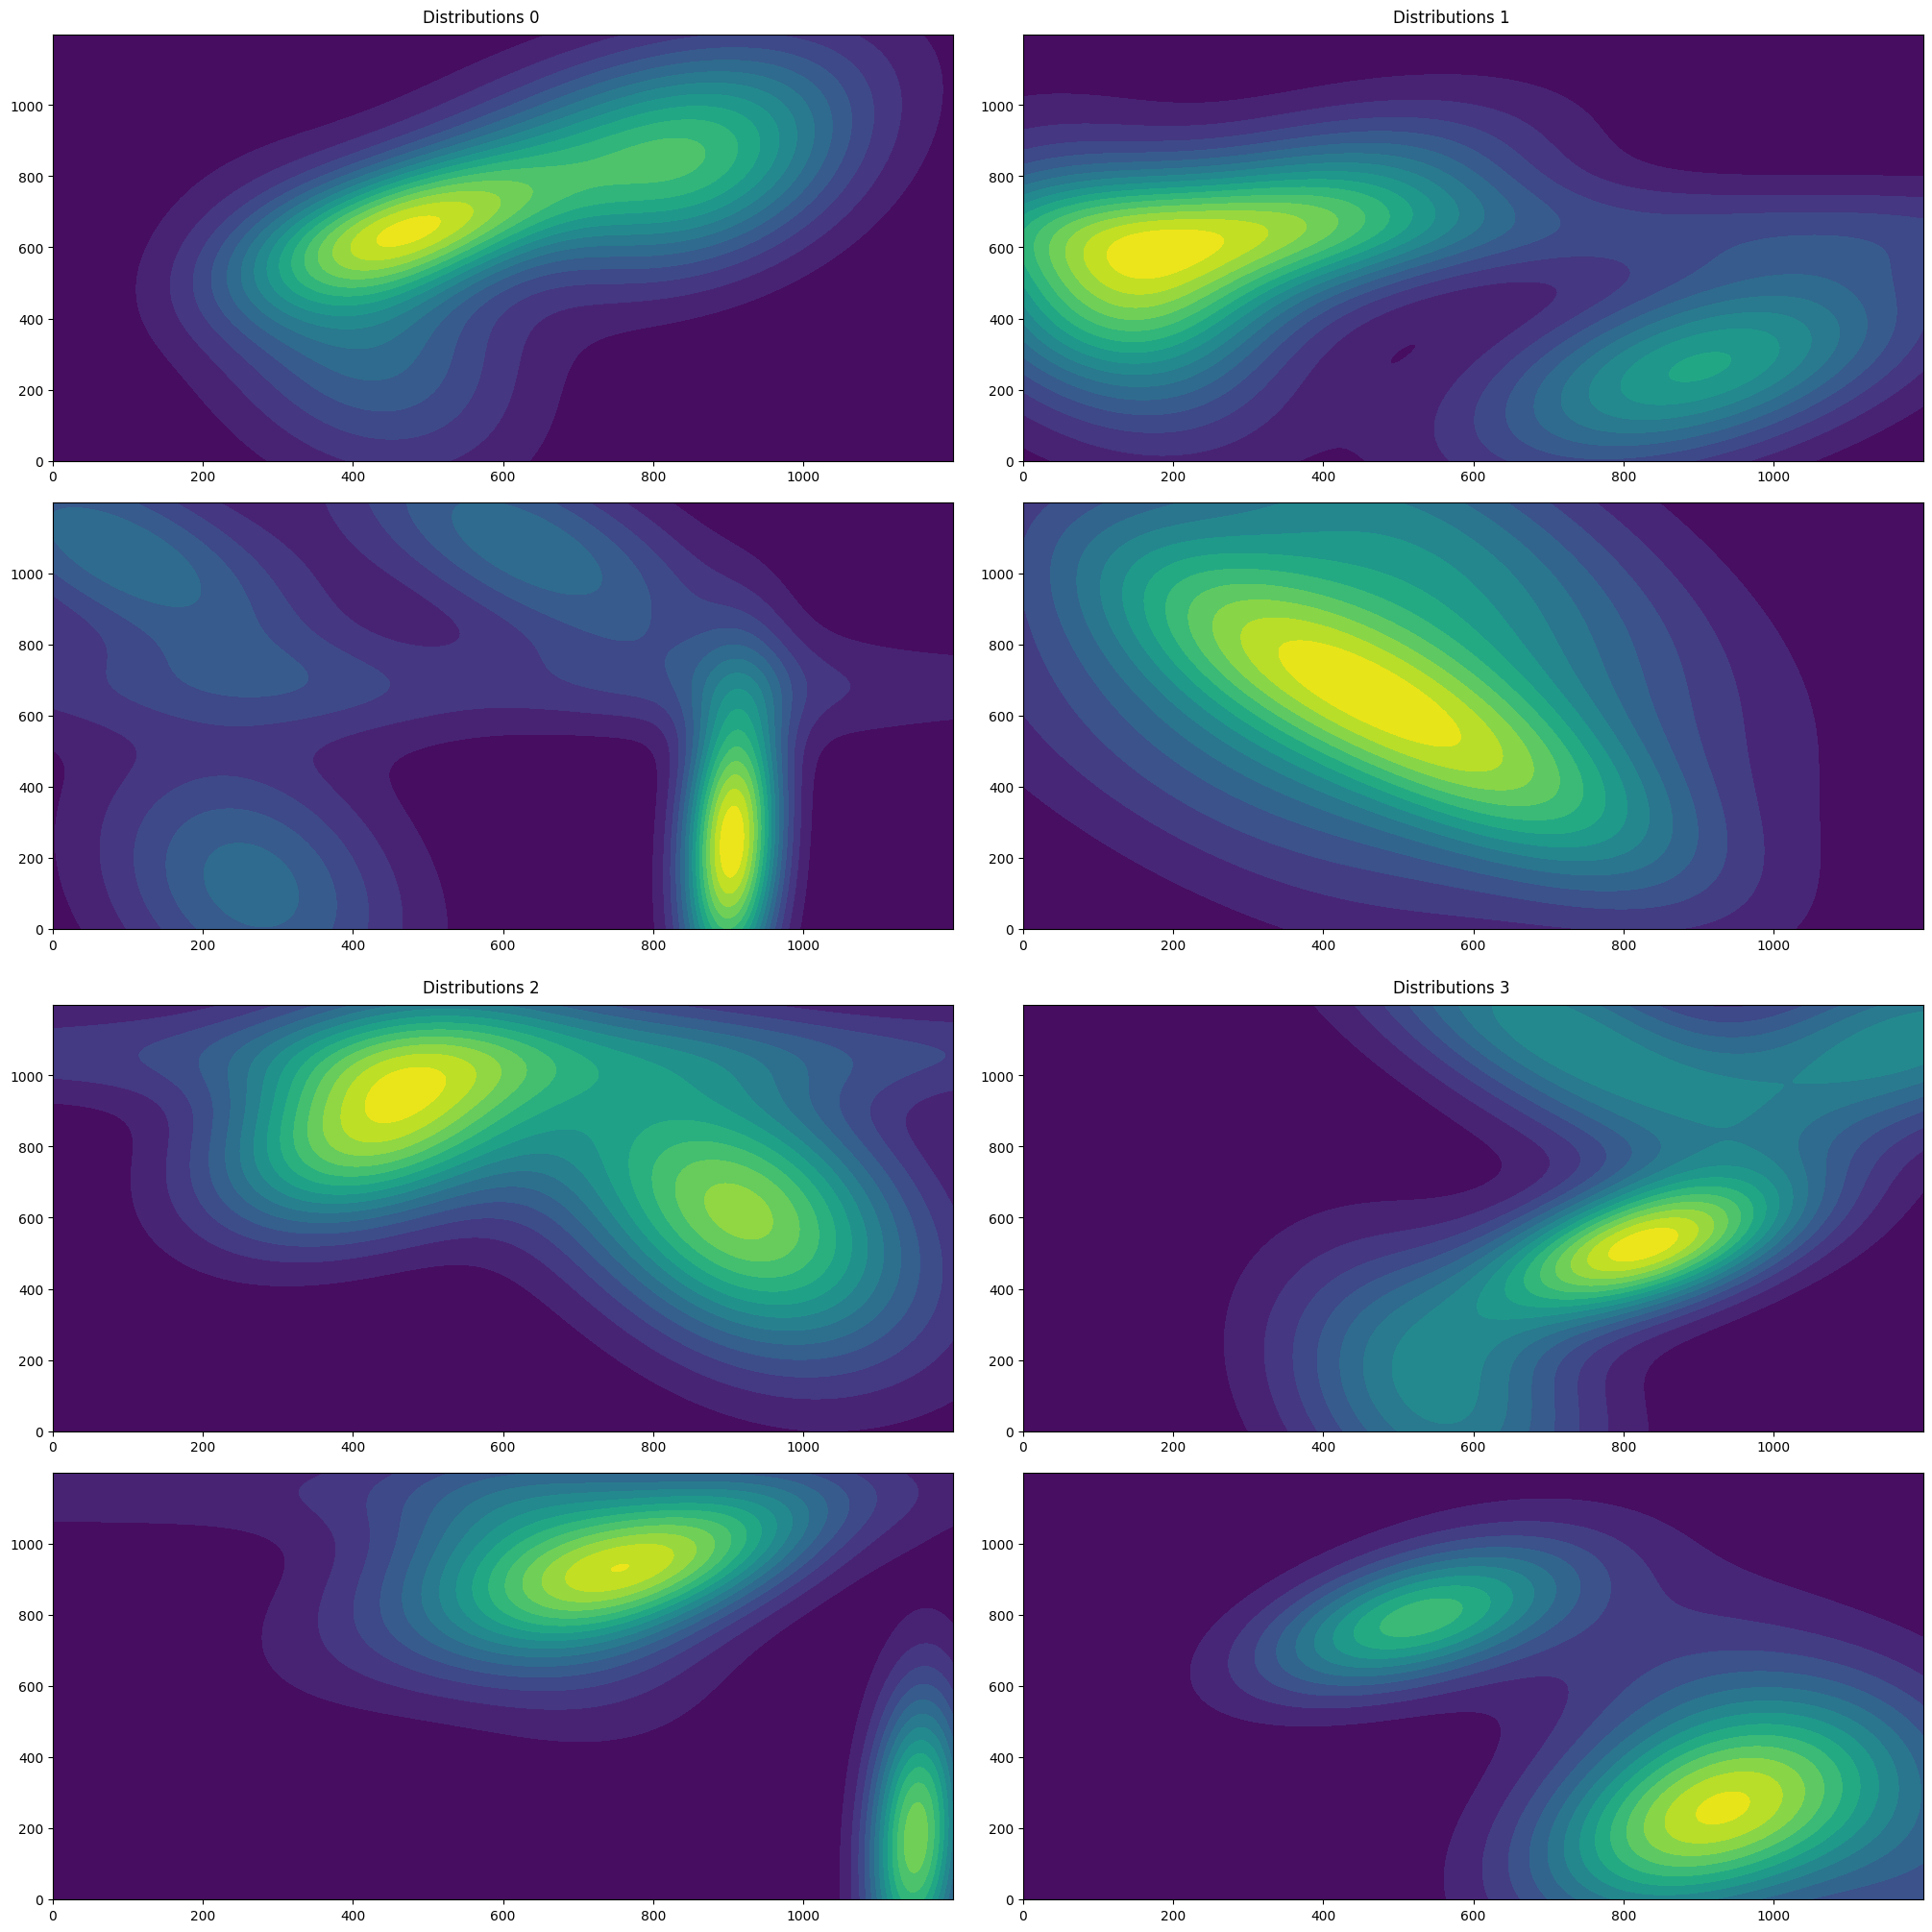

In [3]:
fig = plt.figure(figsize=(20, 20), constrained_layout=True)
subfigs = fig.subfigures(2, 2)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Distributions {outerind}')
    axs = subfig.subplots(2, 1)
    dist1, dist2 = gen.get_fields(4, 5)
    axs[0].contourf(dist1, levels=15)
    axs[1].contourf(dist2, levels=15)
 
plt.show()

>#### 2. Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.

>##### 2.1 Примеры тренировочных данных
Создаём наборы координат (для первого класса 1000 точек, а для второго 1500). Первый класс сосотоит из 4-ёх компонент, а 2-ой из 5-ти. В ячейке ниже можно видеть, как генерируемые пары координат приближают сгенерированные поля нормальных распределений

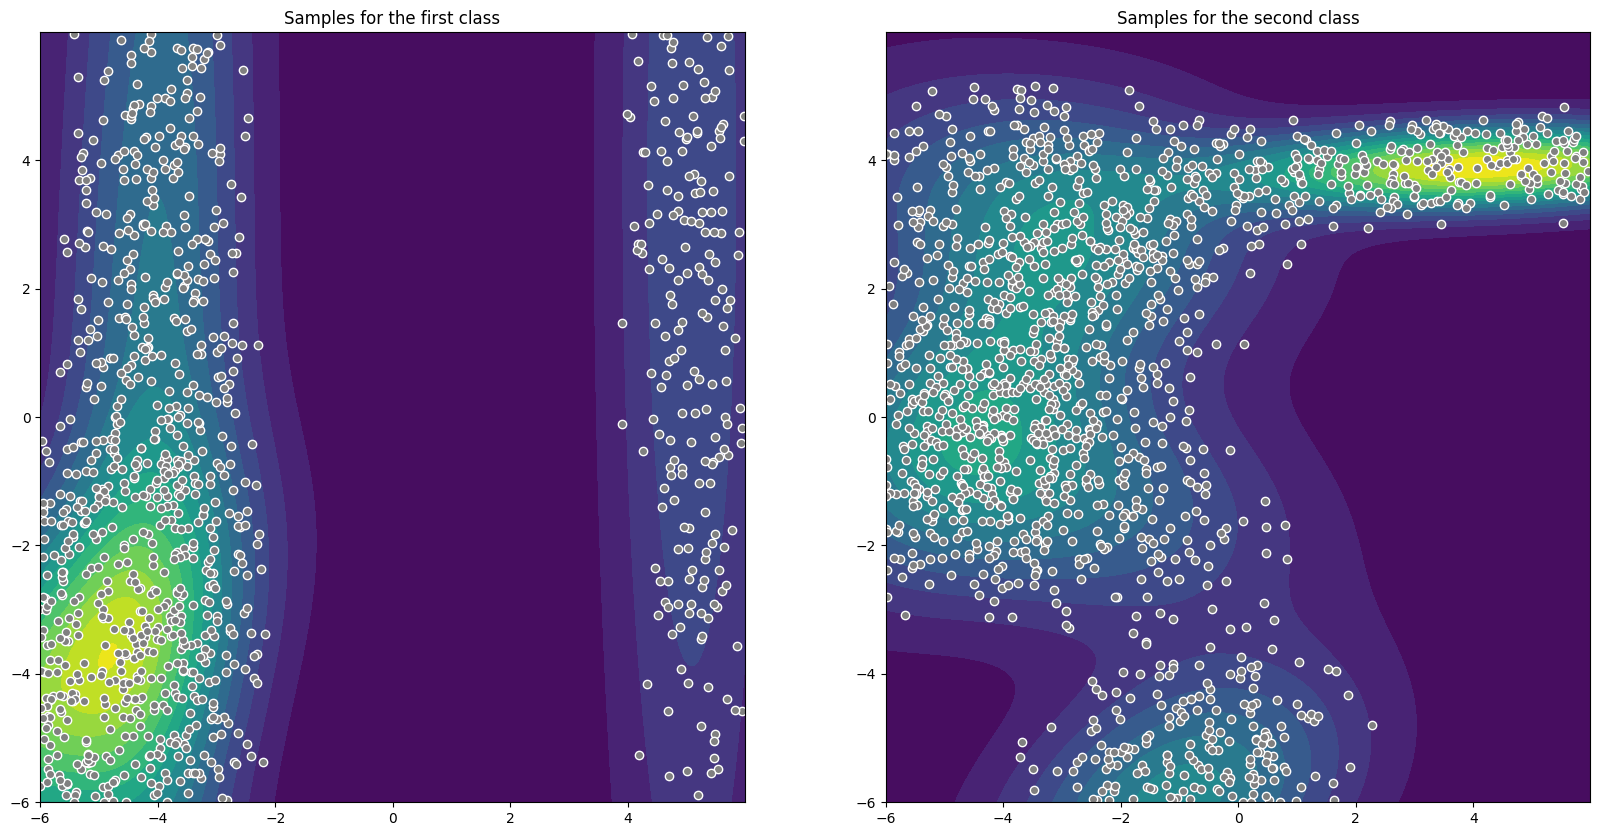

In [4]:
X, y, (field1, field2, grid) = gen.generate_train_data((1000, 1500), 4, 5)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].set_title("Samples for the first class")
ax[0].contourf(gen.grid_x, gen.grid_y, field1, levels=15)
ax[0].scatter(X[y == 1, 0], X[y == 1, 1], c='gray', edgecolors='white')
ax[1].set_title("Samples for the second class")
ax[1].contourf(gen.grid_x, gen.grid_y, field2, levels=15)
ax[1].scatter(X[y == 2, 0], X[y == 2, 1], c='gray', edgecolors='white')

Построим разделяющую плоскость для сгенерированных данных для RandomForestClassifier

In [6]:
def plot_decision_surface(model, pack, fit_model=True):
    X, y, (field1, field2, grid) = pack
    if (fit_model):
        model.fit(X, y)
    pred_surface = model.predict(grid.reshape(grid.shape[0] * grid.shape[1], 2))
    pred_surface = pred_surface.reshape(grid.shape[0], grid.shape[1])
    preds = model.predict(X)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f'Decision function for {model}, accuracy: {model.score(X, y):.4f}')
    cs = ax.contourf(gen.grid_x, gen.grid_y, pred_surface, levels=1)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black')
    ax.scatter(X[preds != y][:, 0], X[preds != y][:, 1], c="red", marker='x')

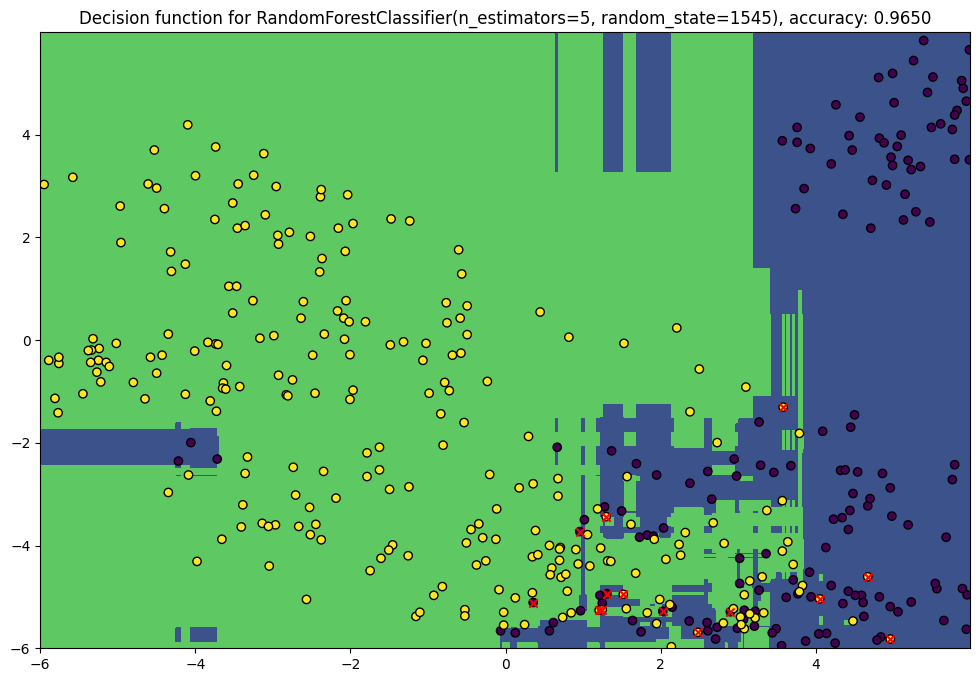

In [7]:
model = RandomForestClassifier(n_estimators=5, random_state=1545)
plot_decision_surface(model,  gen.generate_train_data((150, 250), 4, 5))

Построим разделяющую плоскость для GradientBoostingClassifier

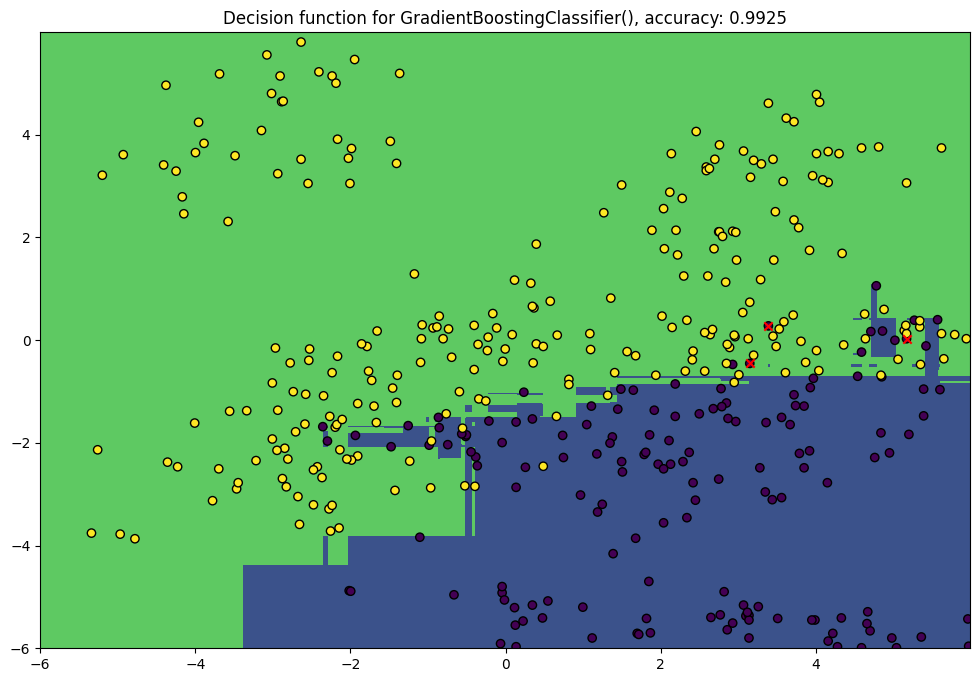

In [8]:
model = GradientBoostingClassifier()
plot_decision_surface(model, gen.generate_train_data((150, 250), 4, 5))

Проверим обобщене на большой выборке для GradientBoostingClassifier

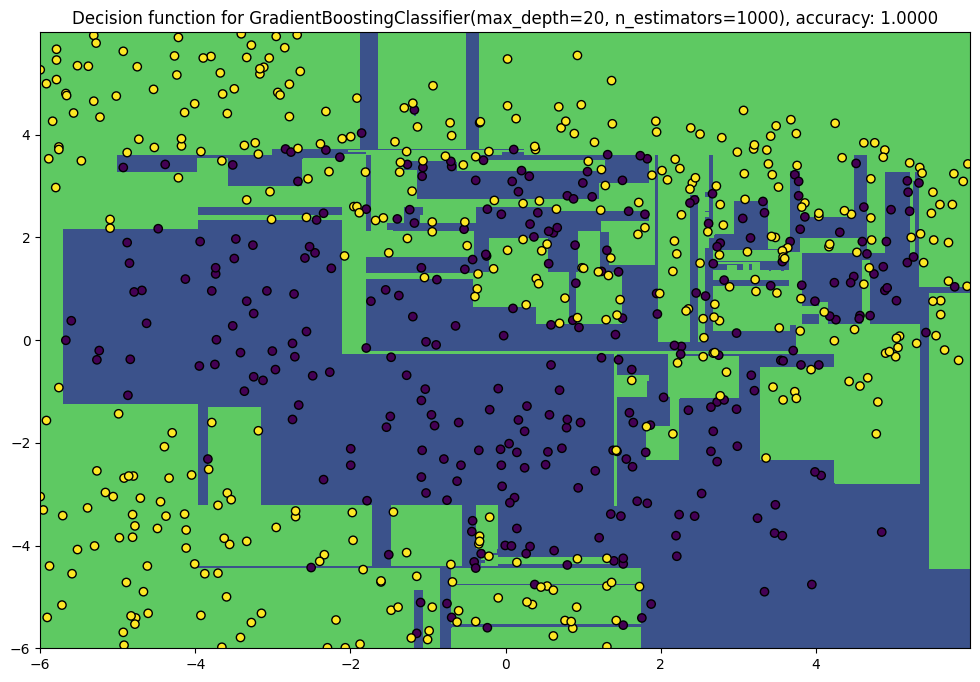

In [9]:
model = GradientBoostingClassifier(n_estimators=1000, max_depth=20)
gen.use_cached = False
plot_decision_surface(model, gen.generate_train_data((300, 400), 4, 5))

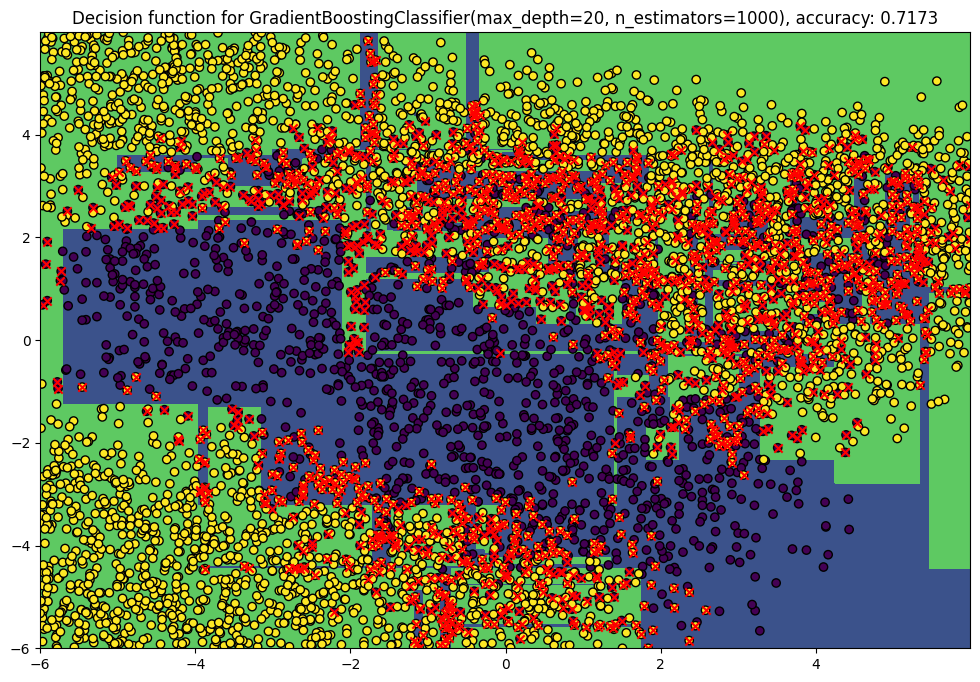

In [10]:
gen.use_cached = True
plot_decision_surface(model, gen.generate_train_data((2000, 4000), 4, 5),  False)

>#### 3. Повторять шаги 4–7 заданное число раз (50–100).
>#### 4. Сгенерировать обучающую выборку заданного размера.
>#### 5. Построить решающую функцию. Вычислить эмпирический риск (число ошибок на обучении).
>#### 6. Сгенерировать контрольную выборку достаточно большого размера (больше 10000 объектов). Вычислить оценку вероятности ошибочной классификации.
>#### 7. Вычислить оценку вероятности ошибочной классификации методом скользящего экзамена (на исходной обучающей выборке).

По сути в этой части работы мы исследуем различные варианты тестирования модели.

В пункте 5 мы вычисляем эмперический риск на ТРЕНИРОВОЧНЫХ ДАННЫХ.

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def steps_holder(iModel = GradientBoostingClassifier(n_estimators=10, max_depth=3)):
    X, y = None, None
    trainset_size = 100
    k_fold_splits = 7
    model = iModel
    epoch = 50

    epoch_stat = pd.DataFrame()
    epoch_stat["emp_risk"] = np.zeros(epoch, dtype=np.float64)
    epoch_stat["error_prob_kfold"] = np.zeros(epoch, dtype=np.float64)
    epoch_stat["error_prob_test"] = np.zeros(epoch, dtype=np.float64)

    def step_4():
        global X, y
        X, y, _ = gen.generate_train_data((40, 60), 4, 5)
        
    def step_5(i):
        global X, y
        model.fit(X, y)
        epoch_stat["emp_risk"][i] = model.score(X, y)

    def step_6(i):
        gen.use_cached = True
        X, y, _ = gen.generate_train_data((5000, 5100), 4, 5)
        epoch_stat["error_prob_test"][i] = model.score(X, y)
        
    def step_7(i):
        global X, y
        model = GradientBoostingClassifier(n_estimators=10, max_depth=3)
        skf = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=500)
        cv_scores = cross_val_score(estimator=model, X=X, y=y,
                                    cv=skf, scoring="accuracy", n_jobs=-1)
        epoch_stat["error_prob_kfold"][i] = np.mean(cv_scores)
        
    for i in range(epoch):
        step_4()
        step_5(i)
        step_6(i)
        step_7(i)
        print(f"Done {i} epoch")
    return epoch_stat

In [ ]:
epoch_stat_gradboost = steps_holder()

Тут можно видеть, что эмперический риск при тестировании на ТРЕНИРОВОЧНЫХ данных ожидаемо низок, так как мы на этих данных и обучались.

Если сравнивать эмперические риски для ТЕСТОВЫХ данных и эмперический риск для КРОССВАЛИДАЦИИ, то можно видеть, что они в среднем одинаковые, но разброс эмперического риска выше, чем для тестовых данных. Это объясняется тем, что кол-во данных, взятых для КРОССВАЛИДАЦИИ значительно меньше, чем для тестовых данных и они беруться с перестановкками (может попасться, как хорошая выборка для теста, так и плохая).

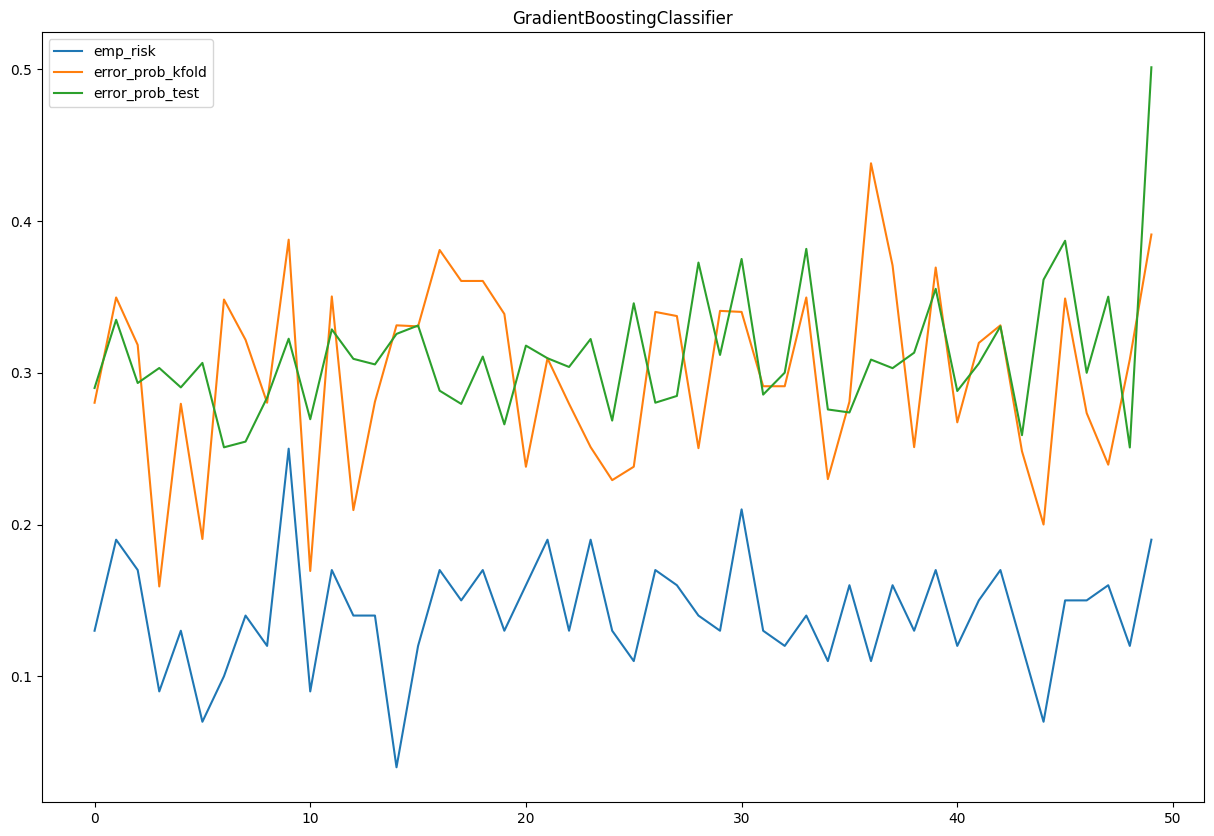

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("GradientBoostingClassifier")
ax.plot(1 - epoch_stat_gradboost["emp_risk"], label="emp_risk")
ax.plot(1 - epoch_stat_gradboost["error_prob_kfold"], label="error_prob_kfold")
ax.plot(1 - epoch_stat_gradboost["error_prob_test"], label="error_prob_test")
ax.legend()

>#### 9. Вычислить средние и стандартные отклонения по каждому столбцу.

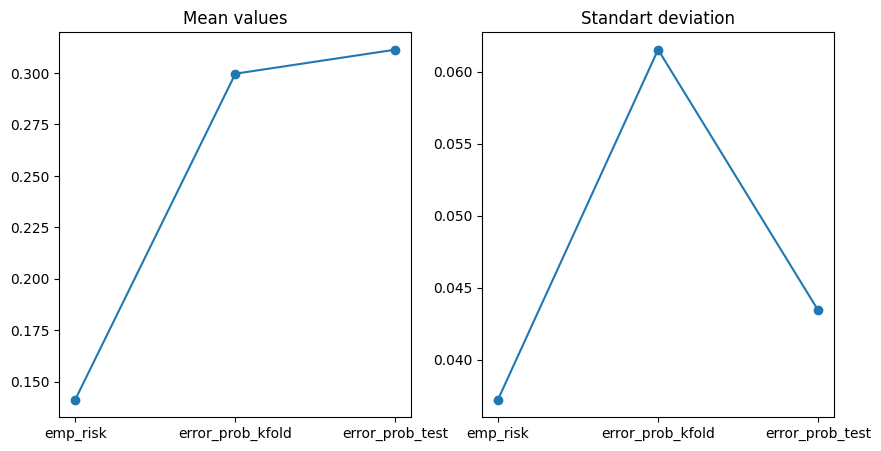

In [17]:
means = (1 - epoch_stat_gradboost).mean(axis=0)
stds = (1 - epoch_stat_gradboost).std(axis=0)
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Mean values")
ax[0].plot(epoch_stat_gradboost.columns, means.values, "o-")
ax[1].set_title("Standart deviation")
ax[1].plot(epoch_stat_gradboost.columns, stds.values, "o-")

>#### 10. Провести аналогичное моделирование, изменив вероятностную модель, или метод классификации, или параметры метода.

In [ ]:
epoch_stat_rf = steps_holder(RandomForestClassifier(n_estimators=50, random_state=1545))

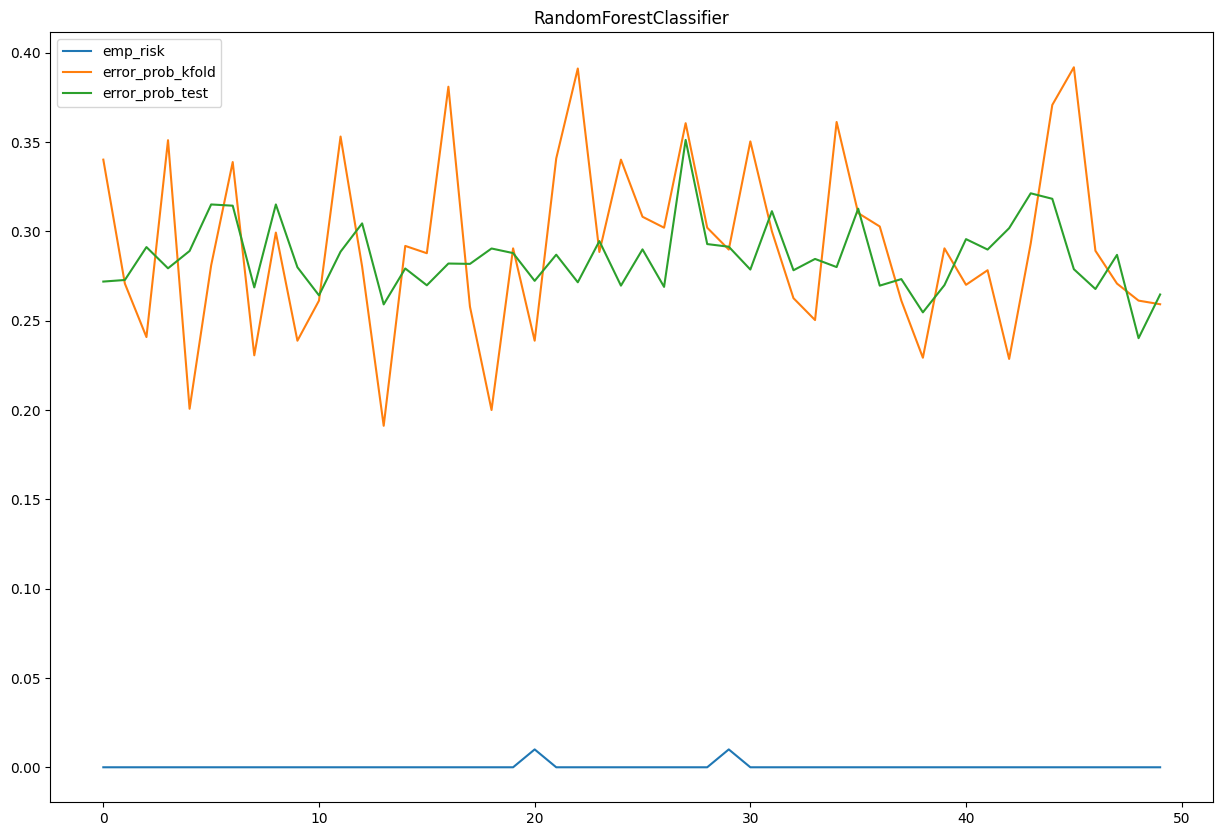

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("RandomForestClassifier")
ax.plot(1 - epoch_stat_rf["emp_risk"], label="emp_risk")
ax.plot(1 - epoch_stat_rf["error_prob_kfold"], label="error_prob_kfold")
ax.plot(1 - epoch_stat_rf["error_prob_test"], label="error_prob_test")
ax.legend()

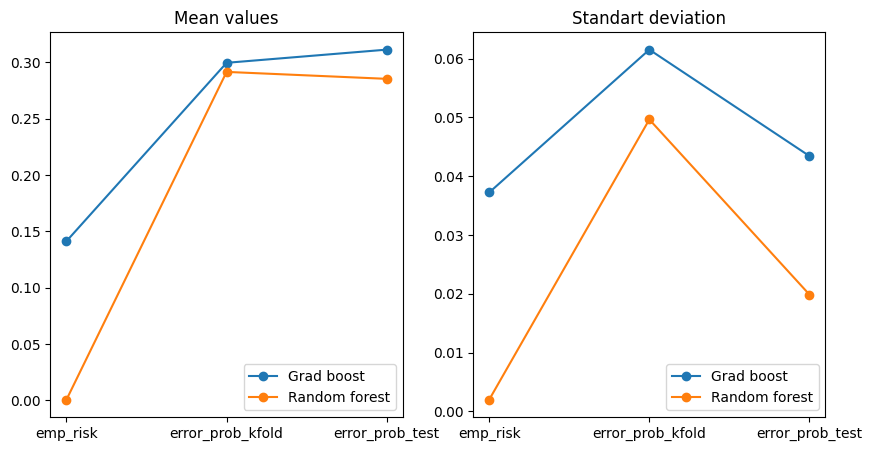

In [20]:
means = (1 - epoch_stat_rf).mean(axis=0)
stds = (1 - epoch_stat_rf).std(axis=0)
meansgb = (1 - epoch_stat_gradboost).mean(axis=0)
stdsgb = (1 - epoch_stat_gradboost).std(axis=0)

fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Mean values")
ax[0].plot(epoch_stat_gradboost.columns, meansgb.values, "o-", label="Grad boost")
ax[0].plot(epoch_stat_rf.columns, means.values, "o-", label="Random forest")
ax[0].legend()
ax[1].set_title("Standart deviation")
ax[1].plot(epoch_stat_gradboost.columns, stdsgb.values, "o-", label="Grad boost")
ax[1].plot(epoch_stat_rf.columns, stds.values, "o-", label="Random forest")
ax[1].legend()

>#### 12.Факультативно: вычислить смещение и разброс для разных моделей в разные ситуациях (bias-variance decomposition).

Bias (смещение) - отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма.

Variance (разброс) - разброс ответов обученного алгоритма относительно среднего ответа.

Смещение показывает, насколько хорошо с помощью данных метода обучения и семейства алгоритмов можно приблизить оптимальный алгоритм.
(Или же доля ошибок алгоритма на тренировочной выборке)

Разброс показывает, насколько сильно может изменяться ответ обученного алгоритма в зависимости от выборки иными словами, она характеризует чувствительность метода обучения к изменениям в выборке.
(Или же насколько хуже алгоритм работает на валидационной (или тестовой) выборке, чем на тренировочной)

![title](1.png)

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

models = [GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0),
          DecisionTreeClassifier(random_state=42, max_depth=2),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          LogisticRegression(random_state=0),
          SVC(kernel='rbf', C=1.0),
          RandomForestClassifier()]

In [10]:
df_bias_variance = pd.DataFrame()
df_bias_variance['classifier'] = np.zeros(len(models))
df_bias_variance['bias_train'] = np.zeros(len(models))
df_bias_variance['variance_train'] = np.zeros(len(models))
df_bias_variance['metric_train'] = np.zeros(len(models))
df_bias_variance['bias_kfold'] = np.zeros(len(models))
df_bias_variance['variance_kfold'] = np.zeros(len(models))
df_bias_variance['metric_kfold'] = np.zeros(len(models))
df_bias_variance['bias_test'] = np.zeros(len(models))
df_bias_variance['variance_test'] = np.zeros(len(models))
df_bias_variance['metric_test'] = np.zeros(len(models))

In [11]:
for i, model in enumerate(models):
    before_fit_model = model
    df_bias_variance.loc[i, "classifier"] = type(model).__name__
    X, y, _ = gen.generate_train_data((100, 100), 4, 5)
    model.fit(X, y)
    _, bias, variance = bias_variance_decomp(model, X, y, X, y, loss='mse')
    df_bias_variance.loc[i, "bias_train"] = bias
    df_bias_variance.loc[i, "variance_train"] = variance
    df_bias_variance.loc[i, "metric_train"] = 1 - model.score(X, y)
    
    gen.use_cached = True
    X_test, y_test, _ = gen.generate_train_data((5000, 5100), 4, 5)
    _, bias, variance = bias_variance_decomp(model, X, y, X_test, y_test, loss='mse')
    df_bias_variance.loc[i, "bias_test"] = bias
    df_bias_variance.loc[i, "variance_test"] = variance
    df_bias_variance.loc[i, "metric_test"] = 1 - model.score(X_test, y_test)
    
    model = before_fit_model
    biases = []
    variances = []
    metric = []
    kf = KFold(n_splits=5, shuffle=False)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        _, bias, variance = bias_variance_decomp(model, X_train, y_train, X_test, y_test, loss='mse')
        biases.append(bias)
        variances.append(variance)
        model.fit(X_train, y_train)
        metric.append(model.score(X_test, y_test))
        
    df_bias_variance.loc[i, "bias_kfold"] = np.mean(biases)
    df_bias_variance.loc[i, "variance_kfold"] = np.mean(variances)
    df_bias_variance.loc[i, "metric_kfold"] = 1 - np.mean(metric)

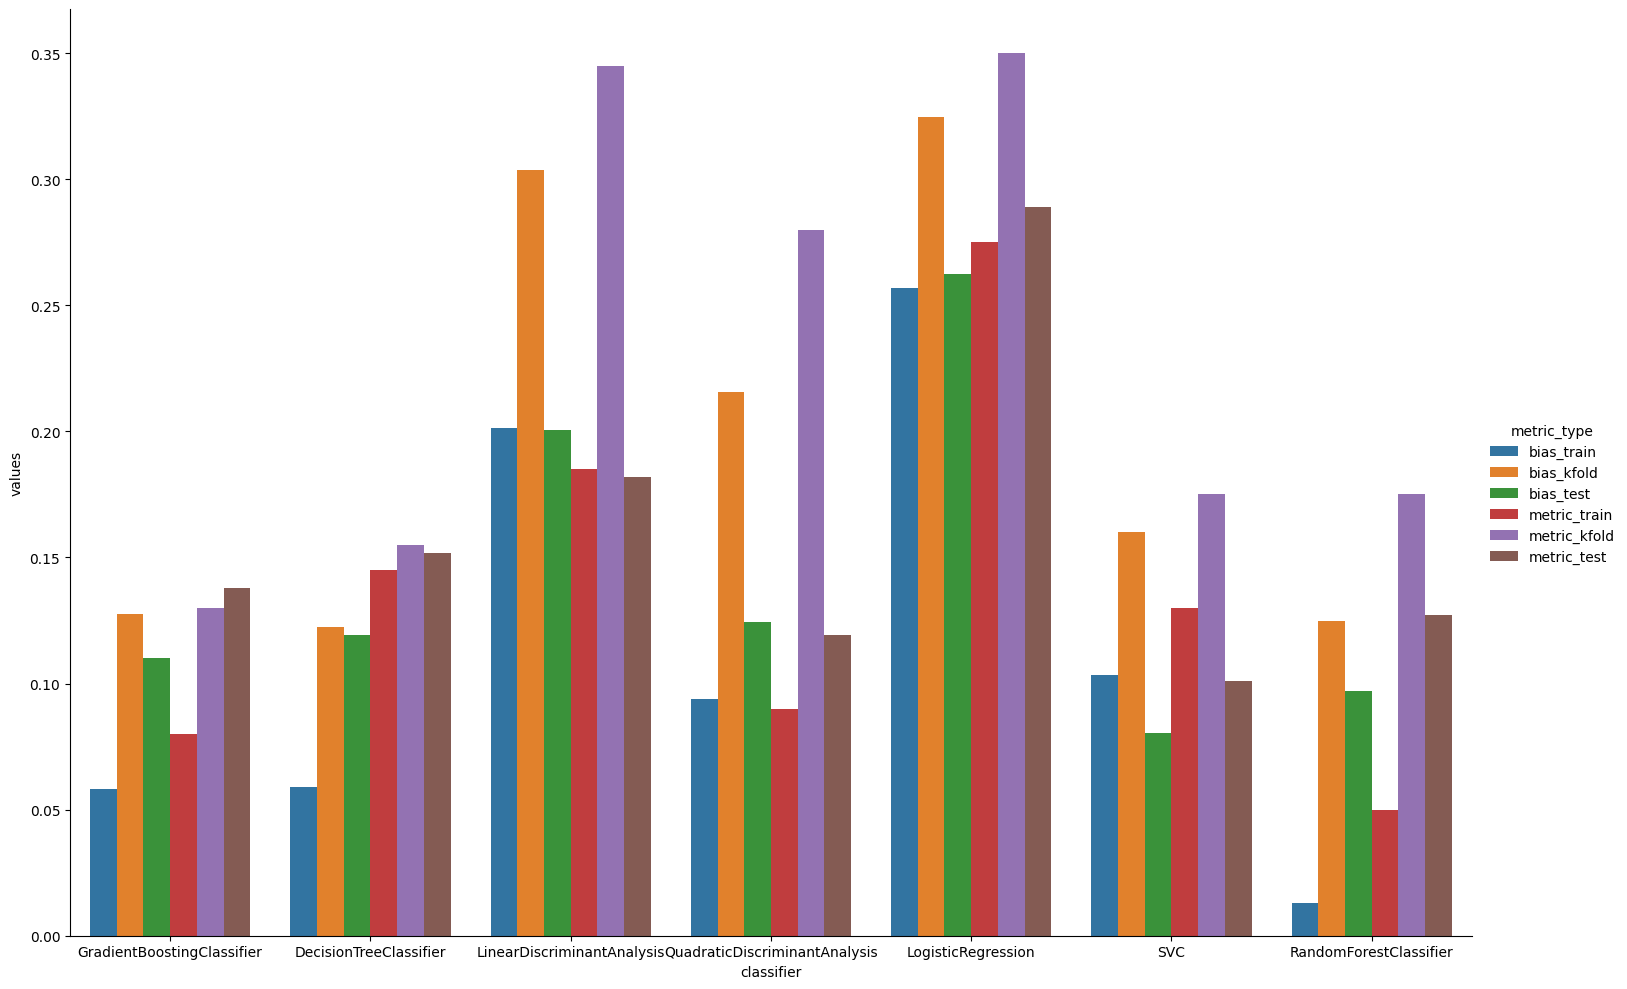

In [13]:
draw_barplot("classifier", ["bias_train", "bias_kfold", "bias_test", "metric_train", "metric_kfold", "metric_test"], df_bias_variance)

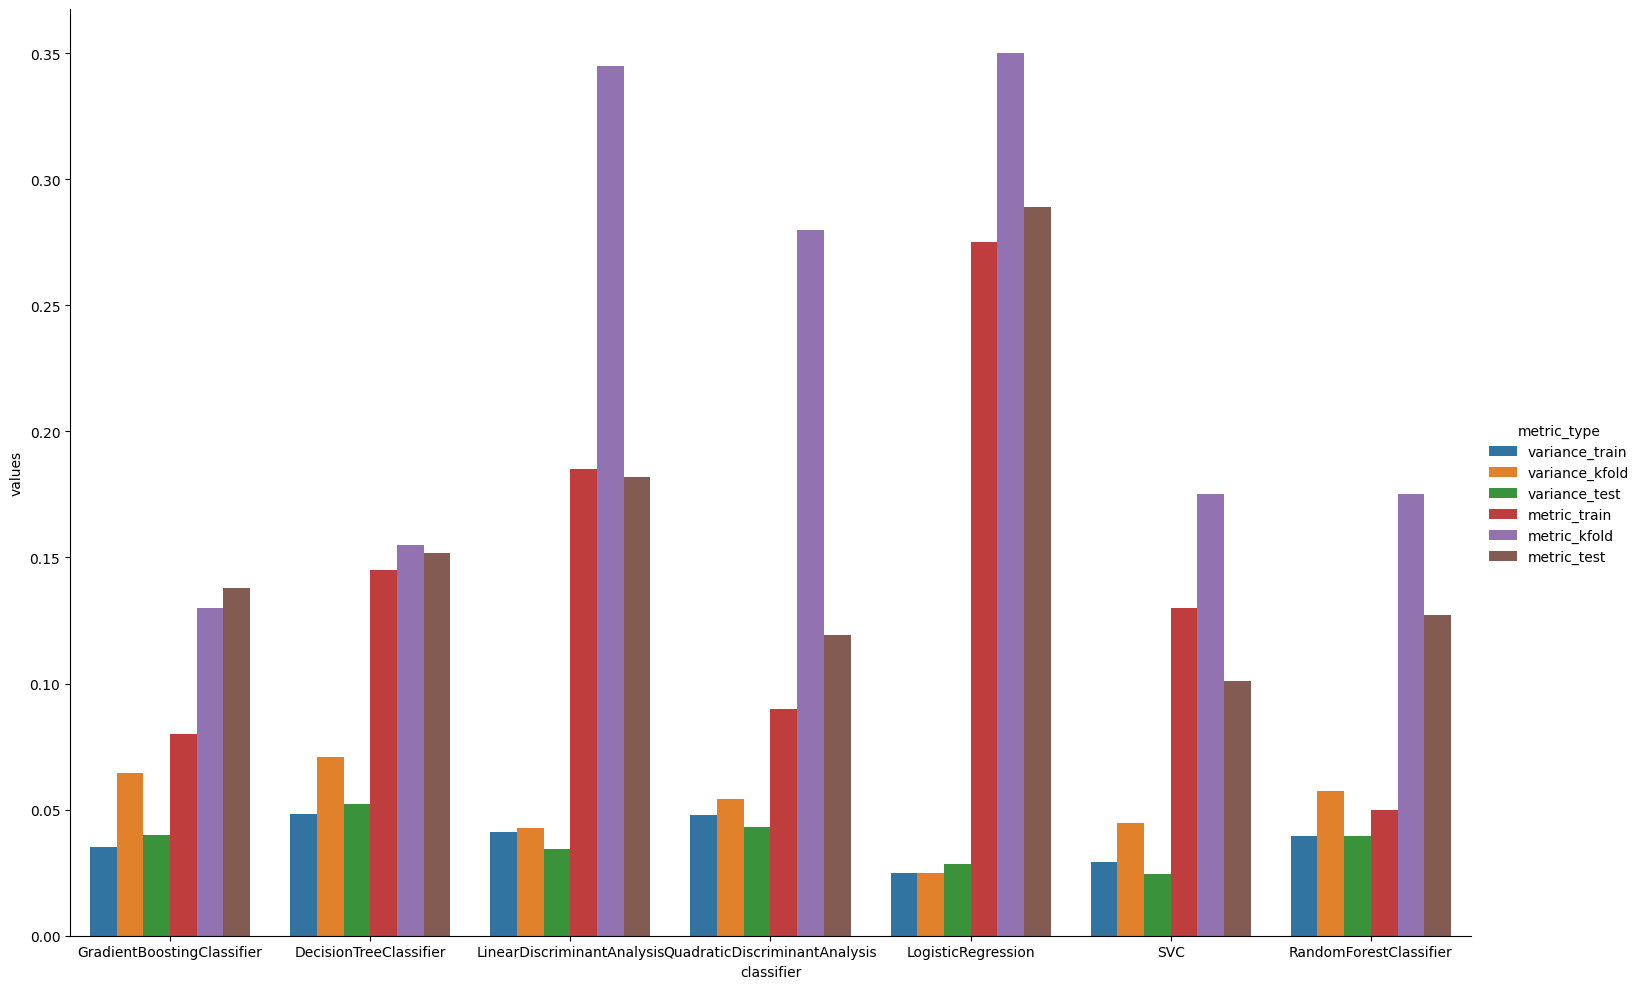

In [14]:
draw_barplot("classifier", ["variance_train", "variance_kfold", "variance_test", "metric_train", "metric_kfold", "metric_test"], df_bias_variance)